In [1]:
from textblob import TextBlob
import csv
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
# sentiment analysis
tweets = pd.read_csv("data/tweets_china_022122.csv")
tweets.columns = ["Date","id1","id2","popularity","content"]

sent = []
sub = []
for tweet in tweets.content:    
    blob = TextBlob(tweet)    
    sent.append(blob.sentiment[0])
    sub.append(blob.sentiment[1])

# add to tweets df
tweets['sentiment'] = pd.Series(sent)
tweets['subjectivity'] = pd.Series(sub)

# aggregate data by day
tweets['date'] = pd.to_datetime(tweets['Date'])
tweets['date'] = tweets['date'].dt.date

tweets1 = tweets.groupby('date').agg('mean')
# drop irrelevant cols
tweets1.drop(['id1', 'id2'], axis = 1, inplace = True)
tweets1.head()

,sentiment,subjectivity
date,,
2022-02-15,0.031779,0.354042
2022-02-16,0.029718,0.340753
2022-02-17,0.027079,0.319380
2022-02-18,0.045980,0.353310
2022-02-19,0.023320,0.332724


In [6]:
# read in sp500 data
# sp 500 data
sp = pd.read_csv('S&P 500 Historical Data.csv', header = 0, thousands=',')
sp['date'] = pd.to_datetime(sp['Date'])
sp['date'] = sp['date'].dt.date
sp.drop('Date', axis = 1, inplace = True)

# merge stock and tweet data
df = tweets1.merge(sp, how = "inner", on = "date")

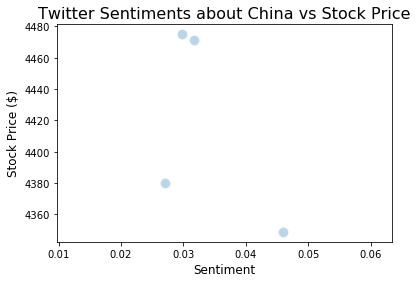

In [7]:
# summary plots?
plt.scatter(x = 'sentiment', y = 'Price', data = df, s = 100, alpha = 0.3, edgecolor = 'white')
plt.title('Twitter Sentiments about China vs Stock Price', fontsize = 16)
plt.ylabel('Stock Price ($)', fontsize = 12)
plt.xlabel('Sentiment', fontsize = 12)
plt.show()

In [8]:
#split train/test data
np.random.seed(5678)
train, test = train_test_split(df, test_size = 0.1, random_state = 42)


# build model
y_train = train.pop('Price')
x_train = train[['sentiment', 'subjectivity']]

Intercept:  3406.9986790060702
Coefficients:  [-8411.24283201  3760.49664533]


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


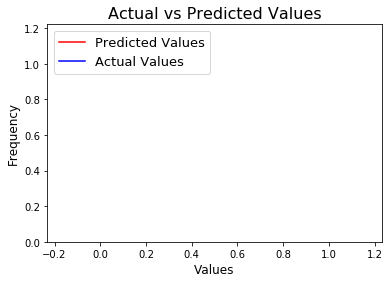

In [9]:
#sklearn
lr = LinearRegression()
lr.fit(x_train,y_train)
yhat = lr.predict(test[['sentiment', 'subjectivity']])
print('Intercept: ', lr.intercept_)
print('Coefficients: ', lr.coef_)
#print('R-Squared :', lr.score(test[['sentiment', 'subjectivity']], test['Price']))

sb.distplot(yhat, hist = False, color = 'r', label = 'Predicted Values')
sb.distplot(test['Price'], hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()
#plt.savefig('ap.png')


In [10]:
#statsmodels
x_var = df[['sentiment', 'subjectivity']]
y_var = df['Price']

sm_x_var = sm.add_constant(x_var)
mlr_model = sm.OLS(y_var, sm_x_var)
mlr_reg = mlr_model.fit()
print(mlr_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     6.605
Date:                Wed, 23 Feb 2022   Prob (F-statistic):              0.265
Time:                        18:26:05   Log-Likelihood:                -16.425
No. Observations:                   4   AIC:                             38.85
Df Residuals:                       1   BIC:                             37.01
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3344.2378    422.912      7.908   

/home/crliu/.local/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
